### Imports

In [1]:
import torch
import numpy as np
import sys 
sys.path.append('/home/21576262@su/masters/src')
from data.data_loading import define_transforms, split_data
import matplotlib.pyplot as plt
import os
import torch.utils.data as data_utils
import random
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torchvision.transforms.functional as TF
import pandas as pd

### Load data

In [4]:
PATCH_SIZE=256
STRIDE=PATCH_SIZE
SEED=42
num_cpus=4
num_classes=2

batch_size=32

model_name = 'resnet'

ResNet = True if model_name == 'resnet' else False
Inception = True if model_name == 'inception' else False

if Inception:
        INPUT_SIZE=299
elif ResNet:
    INPUT_SIZE=224
else:
    INPUT_SIZE=PATCH_SIZE

print(ResNet, Inception)

# using full set of data
img_dir = '/home/21576262@su/masters/data/patches/'
labels_dir = '/home/21576262@su/masters/data/labels/' 

True False


In [5]:
class CustomDataset(Dataset):
    def __init__(self, img_folders, label_files, transform=None):
        self.img_folders = img_folders
        self.label_files = label_files
        self.transform = transform

        self.imgs = [] # Keeps image paths to load in the __getitem__ method
        self.labels = []
        self.cases = []
        # self.HER2_labels = []

        # df_her2_status = get_her2_status_list()

        # Load images and corresponding labels
        for i, (img_folder, label_file) in enumerate(zip(img_folders, label_files)):
            # print("Patch directory", img_folder, "\nLabel file", label_file)
            labels_pt = torch.load(label_file) # Load .pt file
            self.cases.append(img_folder.split('/')[-1])
            # Run through all patches from the case folder
            for i, img in enumerate(os.listdir(img_folder)):
                if os.path.isfile(os.path.join(img_folder, img)) and os.path.isfile(label_file):
                    # print(img_folder + img)
                    case_id = img_folder.split('/')[-1]
                    if img.startswith('._'):
                        img = img.replace('._', '')
                    idx = int(img.replace('.png', '').split("_")[1])
                    self.imgs.append(os.path.join(img_folder, img))
                    self.labels.append(labels_pt[idx].item()) # get label as int
                    # if labels_pt[idx].item() == 1: # if tile is cancerous
                    #     self.HER2_labels.append(df_her2_status[case_id])
                    # else: # if not tumorous, there is no HER2 label
                    #     self.HER2_labels.append(None)
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        # Load image at given index
        image_path = self.imgs[idx]
        image = Image.open(image_path).convert('RGB')
        
        to_tensor = transforms.ToTensor()
        org_image = to_tensor(image) # Convert the PIL image to a tensor
        
        if self.transform is not None: # Apply transformations
            image = self.transform(image)
        
        label = self.labels[idx] # Load corresponding image label

        # her2_label = self.HER2_labels[idx]
        
        # return image, label, her2_label # Return transformed image and label
        return org_image, image, label # Return transformed image and label

In [6]:
# data_transforms = define_transforms(PATCH_SIZE, isResNet=ResNet, isInception=Inception)

In [29]:
# Initialise data transforms
if Inception:
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            # RandomSpecificRotation(),
            transforms.ColorJitter(brightness=0.25, contrast=[0.25, 1.75], saturation=[0.75, 1.25], hue=0.04),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #inception
        ]),
        'val': transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # inception
        ]),
        'test' : transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # inception
        ])
    }
else:
     data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            # RandomSpecificRotation(),
            transforms.ColorJitter(brightness=0.25, contrast=[0.5, 1.75], saturation=[0.75, 1.25], hue=0.04)
        ]),
        'val': transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor()
        ]),
        'test' : transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor()
        ])
    }

In [30]:
print(data_transforms)

{'train': Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ColorJitter(brightness=[0.75, 1.25], contrast=[0.5, 1.75], saturation=[0.75, 1.25], hue=[-0.04, 0.04])
), 'val': Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
), 'test': Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)}


In [31]:
split=[70, 15, 15] # for splitting into train/val/test

train_cases, val_cases, test_cases = split_data(img_dir, split, SEED)

train_img_folders = [img_dir + case for case in train_cases]
val_img_folders = [img_dir + case for case in val_cases]
test_img_folders = [img_dir + case for case in test_cases]

# Contains the file path for each .pt file for the cases used in each of the sets
train_labels = [labels_dir + case + '.pt' for case in train_cases]
val_labels = [labels_dir + case + '.pt' for case in val_cases]
test_labels = [labels_dir + case + '.pt' for case in test_cases]

image_datasets = {
    'train': CustomDataset(train_img_folders, train_labels, transform=data_transforms['train']),
    'val': CustomDataset(val_img_folders, val_labels, transform=data_transforms['val']),
    'test': CustomDataset(test_img_folders, test_labels, transform=data_transforms['test'])
}
# Create training, validation and test dataloaders
dataloaders = {
    'train': data_utils.DataLoader(image_datasets['train'], batch_size=batch_size, num_workers=num_cpus, shuffle=True, drop_last=True),
    'val': data_utils.DataLoader(image_datasets['val'], batch_size=batch_size, num_workers=num_cpus, shuffle=True),
    'test': data_utils.DataLoader(image_datasets['test'], batch_size=batch_size, num_workers=num_cpus, shuffle=True)
}

Number of training patches: 258108 
Number of validation patches 58768 
Number of test patches 47709


In [32]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f22af526730>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f22af722280>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f2284ca5c70>}

## Checking applied data transforms

In [33]:
first_batch = next(iter(dataloaders['train']))

In [34]:
org_imgs = first_batch[0]
imgs = first_batch[1]
labels = first_batch[2]

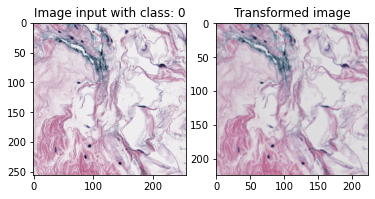

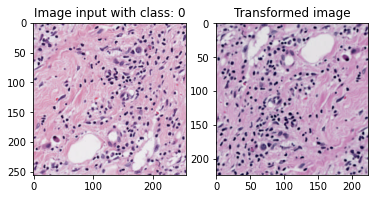

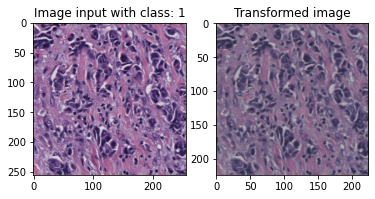

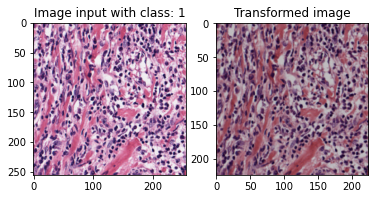

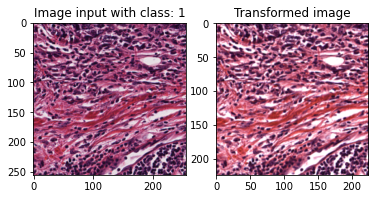

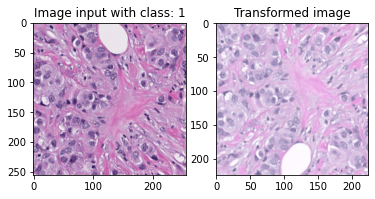

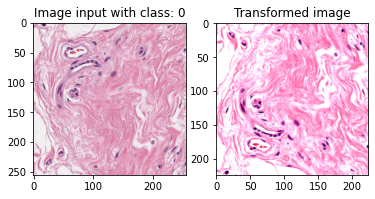

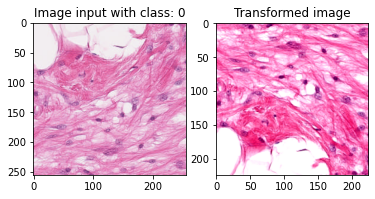

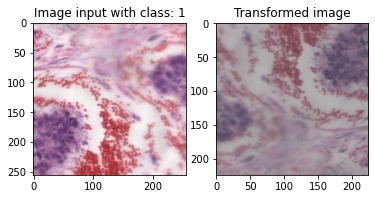

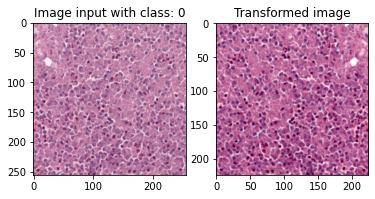

In [35]:
max_idx = 10
for i in range(len(labels)):
    if i < max_idx:
        org_img = np.transpose(org_imgs[i, :, :, :].numpy(), (1, 2, 0))
        img = np.transpose(imgs[i, :, :, :].numpy(), (1, 2, 0))
        lbl = labels[i]
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(org_img)
        ax[0].set_title(f"Image input with class: {lbl}")
        ax[1].imshow(img)
        ax[1].set_title("Transformed image")
    

## Check multiclass dataloader